In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import roc_curve, auc 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [84]:
data1 = pd.read_csv('LoanStats_2018Q1.csv' , encoding='latin-1') 
data2 = pd.read_csv('LoanStats_2018Q2.csv' , encoding='latin-1') 
data3 = pd.read_csv('LoanStats_2018Q3.csv' , encoding='latin-1') 
data4 = pd.read_csv('LoanStats_2018Q4.csv' , encoding='latin-1') 
loans = pd.concat([data1, data2, data3, data4])

In [85]:
thresh_count = len(loans)*0.4

In [86]:
loans = loans .dropna(thresh=thresh_count, axis=1 ) # 若某一列數據缺失的數量超過閥值就會被刪除
loans

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,25000,25000,25000.00000,60 months,21.85%,688.35000,D,D5,Asphalt Supervisor,10+ years,...,75.00000,100.00000,0,0,101234,17039,3300,10220,N,N
1,10000,10000,10000.00000,60 months,12.61%,225.54000,C,C1,Supervisor,4 years,...,91.30000,40.00000,0,0,388400,10710,12500,0,N,N
2,11200,11200,11200.00000,60 months,30.79%,367.82000,G,G1,Client services,< 1 year,...,71.40000,0.00000,0,0,80367,67173,1900,74167,N,N
3,6500,6500,6500.00000,36 months,6.07%,197.95000,A,A2,dental assistant,10+ years,...,93.80000,20.00000,0,0,289008,8665,39000,6500,N,N
4,6000,6000,6000.00000,36 months,10.41%,194.77000,B,B3,Dental Hygienist,1 year,...,100.00000,50.00000,0,0,31925,17000,5200,13125,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128407,23000,23000,23000.00000,36 months,15.02%,797.53000,C,C3,Tax Consultant,10+ years,...,96.40000,14.30000,0,0,296500,40614,47100,21000,N,N
128408,10000,10000,10000.00000,36 months,15.02%,346.76000,C,C3,security guard,5 years,...,73.30000,40.00000,0,0,91403,9323,9100,2000,N,N
128409,5000,5000,5000.00000,36 months,13.56%,169.83000,C,C1,Payoff Clerk,10+ years,...,92.90000,50.00000,0,0,93908,4976,3000,6028,N,N
128410,10000,10000,9750.00000,36 months,11.06%,327.68000,B,B3,NaN,NaN,...,92.00000,0.00000,0,0,57871,16440,20500,10171,N,N


In [87]:
# 缺失值處理——分類型變量
objectColumns = loans.select_dtypes(include=["object"]).columns # 篩選數據類型為 object 的數據
loans[objectColumns] = loans[objectColumns].fillna("Unknown") # 以分類 “Unknown” 填充缺失值

In [88]:
# 缺失值處理——數值型變量
numColumns = loans.select_dtypes(include=[np.number]).columns
from sklearn.impute import SimpleImputer
imr = SimpleImputer(strategy='mean')
imr = imr.fit(loans[numColumns])
loans[numColumns] = imr.transform(loans[numColumns])

In [89]:
# 特徵衍生
loans['installment_feat'] = loans['installment'] / (loans['annual_inc'] / 12)
loans['installment_feat'] = loans['installment_feat'].replace([np.inf], 0)

In [90]:
# 數據過濾
pred_list = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'delinq_2yrs', 'revol_bal', 'total_acc', 'application_type', 'installment_feat']
loans = loans[pred_list]

In [91]:
# 特徵抽象
# 使用 Pandas replace 函數定義新函數
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

# 把貸款狀態 LoanStatus 編碼為：違約=1, 正常=0
pd.value_counts(loans["loan_status"])
loans["loan_status"] = coding(loans["loan_status"], {'Current':0,
                                                     'Fully Paid':0,
                                                     'In Grace Period':1,
                                                     'Late (31-120 days)':1,
                                                     'Late (16-30 days)':1,
                                                     'Charged Off':1, 
                                                     'Default':1})

In [92]:
loans.select_dtypes(include=["object"]).describe().T # 再次檢查數據

,count,unique,top,freq
term,495242,2,36 months,344671
grade,495242,7,B,141365
emp_length,495242,12,10+ years,160382
home_ownership,495242,4,MORTGAGE,239220
verification_status,495242,3,Not Verified,199934
purpose,495242,13,debt_consolidation,259642
application_type,495242,2,Individual,426257


In [93]:
loans

,term,grade,emp_length,home_ownership,verification_status,loan_status,purpose,delinq_2yrs,revol_bal,total_acc,application_type,installment_feat
0,60 months,D,10+ years,MORTGAGE,Source Verified,0,debt_consolidation,1.00000,8657.00000,16.00000,Individual,0.12708
1,60 months,C,4 years,MORTGAGE,Source Verified,0,home_improvement,0.00000,10710.00000,23.00000,Individual,0.03383
2,60 months,G,< 1 year,RENT,Not Verified,0,medical,1.00000,1526.00000,14.00000,Joint App,0.10031
3,36 months,A,10+ years,MORTGAGE,Not Verified,0,debt_consolidation,0.00000,7871.00000,16.00000,Individual,0.04751
4,36 months,B,1 year,RENT,Not Verified,0,credit_card,0.00000,5566.00000,12.00000,Individual,0.05081
...,...,...,...,...,...,...,...,...,...,...,...,...
128407,36 months,C,10+ years,MORTGAGE,Source Verified,1,debt_consolidation,1.00000,22465.00000,28.00000,Individual,0.12760
128408,36 months,C,5 years,MORTGAGE,Not Verified,0,debt_consolidation,3.00000,5634.00000,16.00000,Individual,0.10950
128409,36 months,C,10+ years,MORTGAGE,Not Verified,0,debt_consolidation,1.00000,2597.00000,15.00000,Individual,0.05763
128410,36 months,B,Unknown,RENT,Source Verified,0,credit_card,0.00000,6269.00000,25.00000,Individual,0.08856


In [94]:
# 有序特徵的映射
# 對有序變量 “emp_length”、“grade” 進行轉換
loans["emp_length"] = coding(loans["emp_length"], {"10+ years": 10,
                                                   "9 years": 9,
                                                   "8 years": 8,
                                                   "7 years": 7,
                                                   "6 years": 6,
                                                   "5 years": 5,
                                                   "4 years": 4,
                                                   "3 years": 3,
                                                   "2 years": 2,
                                                   "1 year": 1,
                                                   "< 1 year": 0,
                                                   "n/a": 0,
                                                   "Unknown": 0})
loans["grade"] = coding(loans["grade"], {"A": 1,
                                         "B": 2,
                                         "C": 3,
                                         "D": 4,
                                         "E": 5,
                                         "F": 6,
                                         "G": 7})


In [95]:
loans

,term,grade,emp_length,home_ownership,verification_status,loan_status,purpose,delinq_2yrs,revol_bal,total_acc,application_type,installment_feat
0,60 months,4,10,MORTGAGE,Source Verified,0,debt_consolidation,1.00000,8657.00000,16.00000,Individual,0.12708
1,60 months,3,4,MORTGAGE,Source Verified,0,home_improvement,0.00000,10710.00000,23.00000,Individual,0.03383
2,60 months,7,0,RENT,Not Verified,0,medical,1.00000,1526.00000,14.00000,Joint App,0.10031
3,36 months,1,10,MORTGAGE,Not Verified,0,debt_consolidation,0.00000,7871.00000,16.00000,Individual,0.04751
4,36 months,2,1,RENT,Not Verified,0,credit_card,0.00000,5566.00000,12.00000,Individual,0.05081
...,...,...,...,...,...,...,...,...,...,...,...,...
128407,36 months,3,10,MORTGAGE,Source Verified,1,debt_consolidation,1.00000,22465.00000,28.00000,Individual,0.12760
128408,36 months,3,5,MORTGAGE,Not Verified,0,debt_consolidation,3.00000,5634.00000,16.00000,Individual,0.10950
128409,36 months,3,10,MORTGAGE,Not Verified,0,debt_consolidation,1.00000,2597.00000,15.00000,Individual,0.05763
128410,36 months,2,0,RENT,Source Verified,0,credit_card,0.00000,6269.00000,25.00000,Individual,0.08856


# EDA

In [96]:
# 類別型 column: term, grade, emp_length, home_ownership, verification_status, purpose, application_type
# 數值型 column: delinq_2yrs, revol_bal, total_acc, installment_feat

In [97]:
loans.describe()

,grade,emp_length,loan_status,delinq_2yrs,revol_bal,total_acc,installment_feat
count,495242.00000,495242.00000,495242.00000,495242.00000,495242.00000,495242.00000,495242.00000
mean,2.40928,5.30466,0.04325,0.22925,16270.82999,22.62415,0.32890
std,1.18331,3.93569,0.20342,0.74367,22832.36428,12.10400,39.92818
min,1.00000,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000
25%,1.00000,2.00000,0.00000,0.00000,5304.00000,14.00000,0.04466
50%,2.00000,5.00000,0.00000,0.00000,10832.00000,21.00000,0.07129
75%,3.00000,10.00000,0.00000,0.00000,19867.00000,29.00000,0.10871
max,7.00000,10.00000,1.00000,58.00000,2358150.00000,160.00000,12053.40000


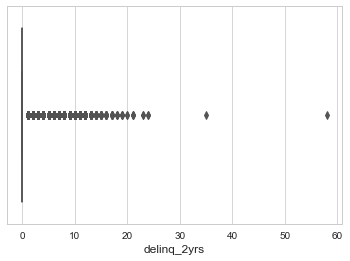

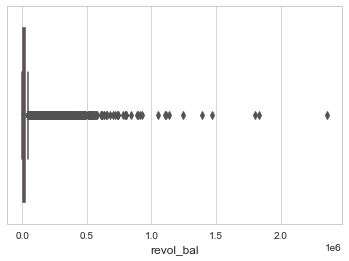

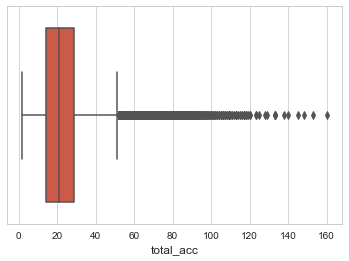

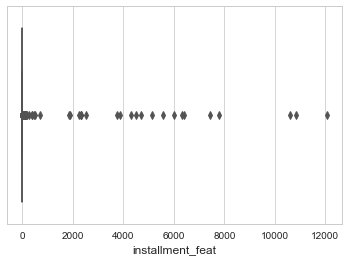

In [98]:
for col in numberic_col:
    sns.boxplot(loans[col],data=loans)
    plt.show()

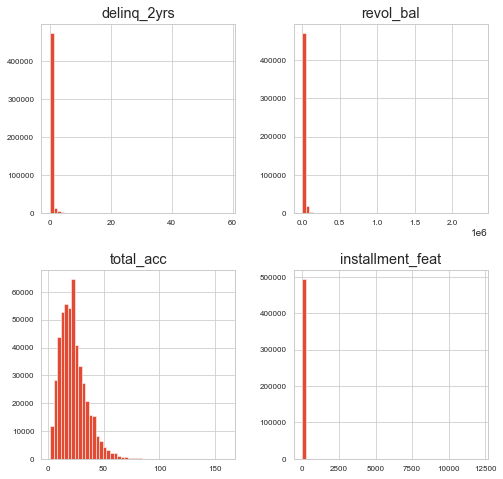

In [99]:
loans[numberic_col].hist(figsize=(8, 8), bins=50, xlabelsize=8, ylabelsize=8); 

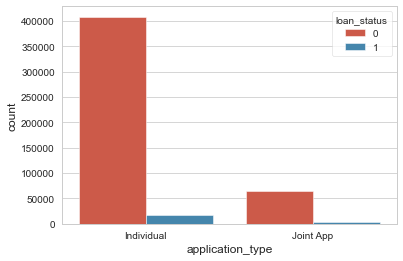

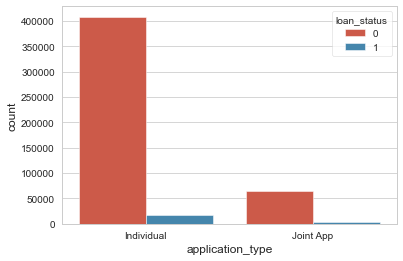

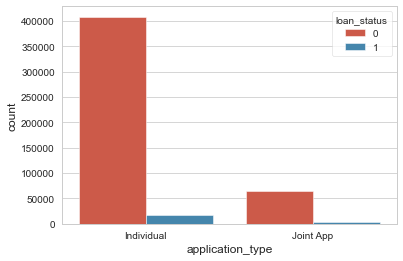

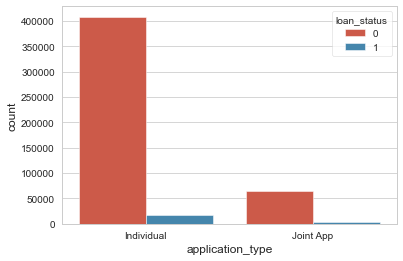

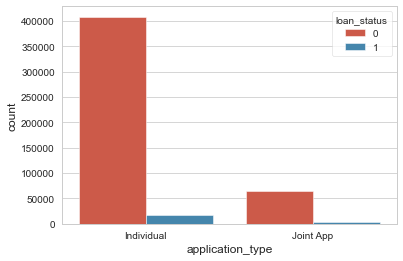

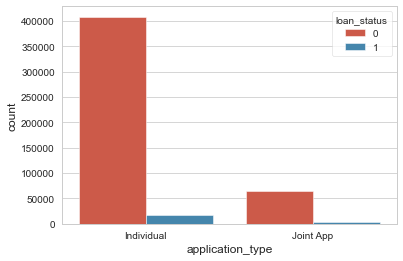

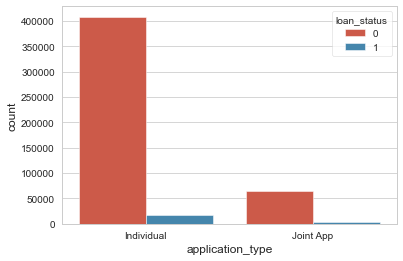

In [100]:
qua_col = ['term','grade','emp_length','home_ownership','verification_status','purpose','application_type']
numberic_col = ['delinq_2yrs','revol_bal','total_acc','installment_feat']
for col in qua_col : 
    sns.countplot(loans[value],hue=loans["loan_status"])
    plt.show()

In [ ]:
for col in qua_col : 
    plt.pie(loans[col].value_counts().values.tolist(),labels=loans[col].value_counts().index.tolist())
    plt.title(col)
    plt.show()

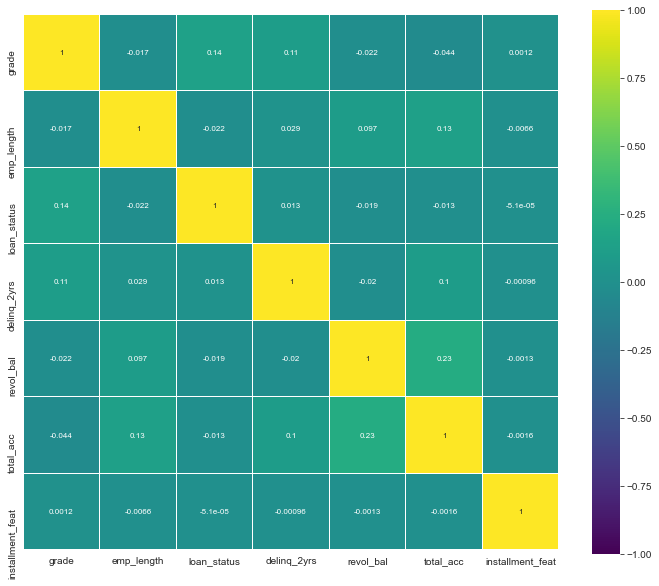

In [102]:
corr = loans.drop(["home_ownership", "verification_status", "application_type","purpose", "term"], axis=1).corr() # We already examined non-number
plt.figure(figsize=(12, 10))

sns.heatmap(corr, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [103]:
# one-hot coding
n_columns = ["home_ownership", "verification_status", "application_type","purpose", "term"] 
dummy_df = pd.get_dummies(loans[n_columns]) # 用 get_dummies 進行 one-hot 編碼
loans = pd.concat([loans, dummy_df], axis=1) # 當 axis = 1的時候，concat 就是行對齊，然後將不同列名稱的兩張表合併
loans = loans.drop(n_columns, axis=1)  # 清除原來的分類變量

In [104]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495242 entries, 0 to 128411
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   grade                                495242 non-null  int64  
 1   emp_length                           495242 non-null  int64  
 2   loan_status                          495242 non-null  int64  
 3   delinq_2yrs                          495242 non-null  float64
 4   revol_bal                            495242 non-null  float64
 5   total_acc                            495242 non-null  float64
 6   installment_feat                     495242 non-null  float64
 7   home_ownership_ANY                   495242 non-null  uint8  
 8   home_ownership_MORTGAGE              495242 non-null  uint8  
 9   home_ownership_OWN                   495242 non-null  uint8  
 10  home_ownership_RENT                  495242 non-null  uint8  
 11  verification_

In [105]:
# 特徵縮放
col = loans.select_dtypes(include=['int64','float64']).columns
col = col.drop('loan_status') # 剔除目標變量
loans_ml_df = loans # 複製數據至變量 loans_ml_df
from sklearn.preprocessing import StandardScaler # 導入模塊
sc = StandardScaler() # 初始化縮放器
loans_ml_df[col] = sc.fit_transform(loans_ml_df[col]) # 對數據進行標準化
loans_ml_df.head() # 查看經標準化後的數據

,grade,emp_length,loan_status,delinq_2yrs,revol_bal,total_acc,installment_feat,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,1.34429,1.19302,0,1.03642,-0.33347,-0.54727,-0.00505,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0.49921,-0.33149,0,-0.30827,-0.24355,0.03105,-0.00739,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,3.87956,-1.34783,0,1.03642,-0.64579,-0.71250,-0.00573,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,-1.19097,1.19302,0,-0.30827,-0.36789,-0.54727,-0.00705,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.34588,-1.09375,0,-0.30827,-0.46885,-0.87774,-0.00696,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [106]:
# 構建 X 特徵變量和 Y 目標變量
x_val = loans_ml_df.drop(columns = ['loan_status'])
y_val = loans_ml_df['loan_status']

In [108]:
# 處理不平衡數據
from imblearn.over_sampling import SMOTE # 導入 SMOTE 算法模塊
sm = SMOTE(random_state=42)    # 處理過採樣的方法
X, y = sm.fit_sample(x_val, y_val)
print('通過 SMOTE 方法平衡正負樣本後')
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('樣本個數：{}; 正樣本佔{:.2%}; 負樣本佔{:.2%}'.format(n_sample, n_pos_sample / n_sample, n_neg_sample / n_sample))
print('特徵維數：', X.shape[1])

通过SMOTE方法平衡正负样本后
样本个数：947646; 正样本占50.00%; 负样本占50.00%
特征维数： 30


In [109]:
# cross-validation
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) # random_state = 0 每次切分的數據都一樣

In [110]:
import sklearn.metrics as metrics

# Evaluation Function
def Evaluation(y_test, preds):
    print("Confusion Matrix:")
    print(metrics.confusion_matrix(y_test, preds))
    print(metrics.classification_report(y_test, preds))
    print("Area under the ROC curve : %f" % metrics.roc_auc_score(y_test, preds))

In [111]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression() # 構建邏輯回歸分類器
clf1.fit(X_train, y_train)
pred1 = clf1.predict(X_test)
Evaluation(y_test, pred1)

Confusion Matrix:
[[100846  41629]
 [ 50940  90879]]
              precision    recall  f1-score   support

           0       0.66      0.71      0.69    142475
           1       0.69      0.64      0.66    141819

    accuracy                           0.67    284294
   macro avg       0.68      0.67      0.67    284294
weighted avg       0.68      0.67      0.67    284294

Area under the ROC curve : 0.674313


<Figure size 432x288 with 0 Axes>

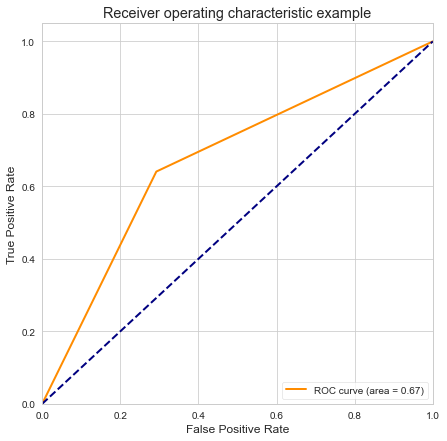

In [115]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, pred1) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ### 計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ### 假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [116]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier() # 構建分類隨機森林分類器
clf2.fit(X_train, y_train)
pred2 = clf2.predict(X_test)
Evaluation(y_test, pred2)

Confusion Matrix:
[[133450   9025]
 [  7141 134678]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94    142475
           1       0.94      0.95      0.94    141819

    accuracy                           0.94    284294
   macro avg       0.94      0.94      0.94    284294
weighted avg       0.94      0.94      0.94    284294

Area under the ROC curve : 0.943151


<Figure size 432x288 with 0 Axes>

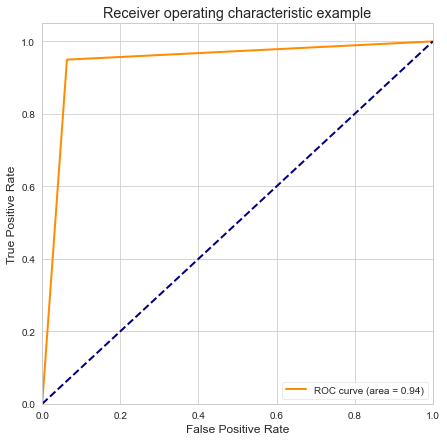

In [117]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, pred2) ### 計算真正率和假正率
roc_auc = auc(fpr,tpr) ### 計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ### 假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [118]:
# XGBoost
from sklearn.ensemble import XGBClassifier
XGBoost_model = XGBClassifier(n_estimators = 100, max_features = 100, max_depth = 5, learning_rate = 0.1)
XGBoost_model.fit(X_train, y_train)
pred3 = XGBoost_model.predict(X_test)
Evaluation(y_test, pred3)

NameError: name 'XGBClassifier' is not defined

In [ ]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, pred3) ### 計算真正率和假正率
roc_auc = auc(fpr,tpr) ### 計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ### 假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# GBDT
from sklearn.ensemble import GradientBoostingClassifier
GBDT_model = GradientBoostingClassifier(n_estimators = 100, max_features = 100, max_depth = 5, learning_rate = 0.1)
GBDT_model.fit(X_train, y_train)
pred4 = GBDT_model.predict(X_test)
Evaluation(y_test, pred4)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, pred4) ### 計算真正率和假正率
roc_auc = auc(fpr,tpr) ### 計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ### 假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# LightGBM
from sklearn.ensemble import LGBMClassifier
LightGBM_model = LGBMClassifier(n_estimators = 100, num_leaves = 100, max_depth = 5, learning_rate = 0.1)
LightGBM_model.fit(X_train, y_train)
pred5 = LightGBM_model.predict(X_test)
Evaluation(y_test, pred5)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, pred5) ### 計算真正率和假正率
roc_auc = auc(fpr,tpr) ### 計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ### 假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()